In [1]:
#coding=utf-8
from keras.models import load_model
from utils.sample import Sample
from utils.black_scholes import raiz_ratio, d1_ratio, call_price_ratio
from utils.biseccion import bisec
import time
import pickle
import math
import numpy as np

from scipy.optimize import brentq
from sklearn.metrics import r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd

GPUs = len(tf.config.experimental.list_physical_devices('GPU'))
CPUs = len(tf.config.experimental.list_physical_devices('CPU'))

if GPUs > 0:
    
    print("Num GPUs Available: ", GPUs)
    print("Num CPUs Available: ", CPUs)
    config = tf.compat.v1.ConfigProto( device_count = \
                                      {'GPU': GPUs , 'CPU': CPUs}) 
    sess = tf.compat.v1.Session(config=config) 
    tf.compat.v1.keras.backend.set_session(sess)


Using TensorFlow backend.


In [2]:
wide = Sample(ratio=[0.4, 1.6], T=[0.2, 1.1],
              r=[0.02, 0.1], o=[0.01, 1])

N = 10**5 # Tamaño de la muestra

wide.create('wide', N=N)
x_wide, y_wide = wide.open('wide')

narrow = Sample(ratio=[0.5, 1.5], T=[0.3, 0.95],
                r=[0.03, 0.08], o=[0.02, 0.9])
narrow.create('narrow', N=N)
x_narrow, y_narrow = narrow.open('narrow')


wide is done ...
narrow is done ...


In [3]:
model = load_model('models/first.h5')

wide_f = pd.DataFrame(x_wide,
                    columns=['c/k', 'ratio', 'r', 'T'])
wide_f['o'] = y_wide
wide_predict = model.predict(x_wide)
wide_f['predicted'] = wide_predict
wide_f['diff'] = wide_f['o'] - wide_f['predicted']
wide_f['error'] = wide_f['diff'].apply(abs)

narrow_f = pd.DataFrame(x_narrow,
                    columns=['c/k', 'ratio', 'r', 'T'])
narrow_f['o'] = y_narrow
narrow_predict = model.predict(x_narrow)
narrow_f['predicted'] = narrow_predict
narrow_f['diff'] = narrow_f['o'] - narrow_f['predicted']
narrow_f['error'] = narrow_f['diff'].apply(abs)


In [4]:




wide_mse, wide_mae, wide_mape = tuple(model.evaluate(x_wide, y_wide)[1:])

narrow_mse, narrow_mae, narrow_mape = tuple(model.evaluate(x_narrow, y_narrow)[1:])


st = 'mse: {}\nmae: {}\nmape: {}'
print('\nWide:\n'+st.format(wide_mse, wide_mae, wide_mape))
print('\n\nNarrow:\n'+st.format(narrow_mse, narrow_mae, narrow_mape))

100000/100000 [==============================] - 10s 100us/step

Wide:
mse: 0.0003151634300593287
mae: 0.006002932786941528
mape: 9.2267484664917


Narrow:
mse: 0.00014659890439361334
mae: 0.0040558758191764355
mape: 5.3966169357299805


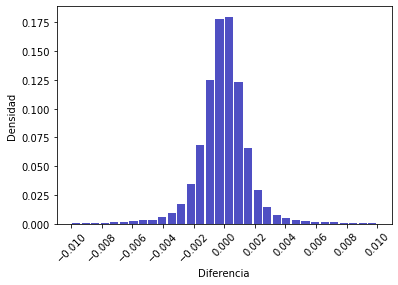

In [5]:



bins = np.linspace(-0.01, 0.01, 33)
plt.hist(wide_f['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.ylabel('Densidad')

plt.xticks(np.linspace(-0.01, 0.01, 11), rotation=45)
plt.xlabel('Diferencia')

plt.savefig('Predic_w_n',dpi=300, bbox_inches='tight')
plt.show()

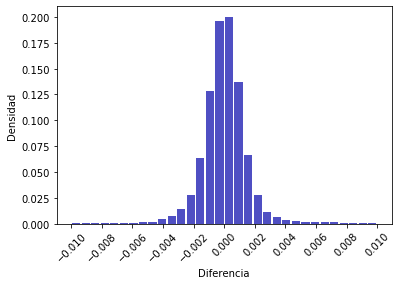

In [6]:


bins = np.linspace(-0.01, 0.01, 33)
plt.hist(narrow_f['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.ylabel('Densidad')

plt.xticks(np.linspace(-0.01, 0.01, 11), rotation=45)
plt.xlabel('Diferencia')

plt.savefig('Predic_n_n',dpi=300, bbox_inches='tight')

plt.show()

In [7]:
#porcetaje que no se grafico con la muestra amplia
p = 100*len(wide_f[wide_f['error'] > 0.01])/N
print('No se grafico un {}% de la muestra amplia'.format(p))

#porcetaje que no se grafico con la muestra angosta
p = 100*len(narrow_f[narrow_f['error'] > 0.01])/N
print('\nNo se grafico un {}% de la muestra angosta'.format(p))

No se grafico un 10.922% de la muestra amplia

No se grafico un 8.592% de la muestra angosta


In [8]:
# r2 https://en.wikipedia.org/wiki/Coefficient_of_determination
r2_n = r2_score(y_narrow, narrow_f['predicted'])
r2_w = r2_score(y_wide, wide_f['predicted'])
print('r2 muestra amplia: ', r2_w)
print('\nr2 muestra angosta: ', r2_n)

r2 muestra amplia:  0.9961164982048422

r2 muestra angosta:  0.997727314388154


# Red logaritmica

In [9]:
wide = Sample(ratio=[0.4, 1.6], T=[0.2, 1.1],
              r=[0.02, 0.1], o=[0.01, 1])
N = 10**5
wide.create('wide', log=True, N=N)
x_wide, y_wide = wide.open('wide', log=True)

narrow = Sample(ratio=[0.5, 1.5], T=[0.3, 0.95],
                r=[0.03, 0.08], o=[0.02, 0.9])

narrow.create('narrow',log=True, N=N)
x_narrow, y_narrow = narrow.open('narrow', log=True)


wide is done ...
narrow is done ...


In [10]:
model = load_model('models/second.h5')

wide_s = pd.DataFrame(x_wide,
                    columns=['c/k', 'ratio', 'r', 'T'])
wide_s['o'] = y_wide
wide_predict = model.predict(x_wide)
wide_s['predicted'] = wide_predict
wide_s['diff'] = wide_s['predicted'] - wide_s['o'] 
wide_s['error'] = wide_s['diff'].apply(abs)

narrow_s = pd.DataFrame(x_narrow,
                    columns=['c/k', 'ratio', 'r', 'T'])
narrow_s['o'] = y_narrow
narrow_predict = model.predict(x_narrow)
narrow_s['predicted'] = narrow_predict
narrow_s['diff'] = narrow_s['predicted'] - narrow_s['o']  
narrow_s['error'] = narrow_s['diff'].apply(abs)


wide_mse, wide_mae, wide_mape = tuple(model.evaluate(x_wide, y_wide)[1:])

narrow_mse, narrow_mae, narrow_mape = tuple(model.evaluate(x_narrow,
                                                           y_narrow)[1:])


st = 'mse: {}\nmae: {}\nmape: {}'
print('\nWide:\n'+st.format(wide_mse, wide_mae, wide_mape))
print('\n\nNarrow:\n'+st.format(narrow_mse, narrow_mae, narrow_mape))

100000/100000 [==============================] - 10s 104us/step

Wide:
mse: 4.675710485457785e-08
mae: 0.00016672945639584213
mape: 0.05182995647192001


Narrow:
mse: 4.0047115845709413e-08
mae: 0.0001563939149491489
mape: 0.052386991679668427


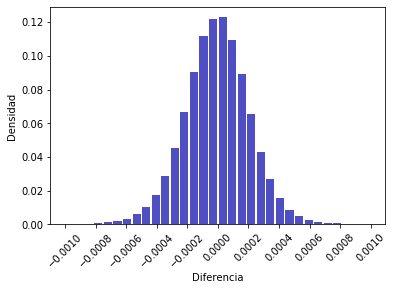

In [11]:


bins = np.linspace(-0.001, 0.001, 33)
plt.hist(wide_s['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.ylabel('Densidad')

plt.xticks(np.linspace(-0.001, 0.001, 11), rotation=45)
plt.xlabel('Diferencia')

plt.savefig('Predic_w_log_mil',dpi=300, bbox_inches='tight')

plt.show()

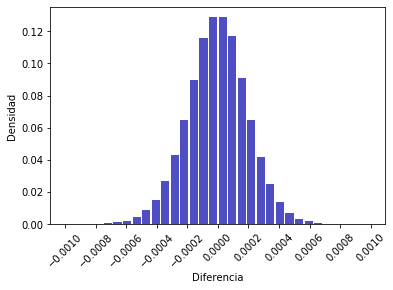

In [12]:


bins = np.linspace(-0.001, 0.001, 33)
plt.hist(narrow_s['diff'], bins, weights=np.ones(N) / N,
                            color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.ylabel('Densidad')
plt.xlabel('Diferencia')
plt.xticks(np.linspace(-0.001, 0.001, 11), rotation=45)

plt.xlabel('Diferencia')

plt.savefig('Predic_n_log_mil',dpi=300, bbox_inches='tight')

plt.show()

In [13]:
#porcetaje que no se grafico con la muestra amplia
p = 100*len(wide_s[wide_s['error'] > 0.001])/N
print('No se grafico un {}% de la muestra amplia'.format(p))

#porcetaje que no se grafico con la muestra angosta
p = 100*len(narrow_s[narrow_s['error'] > 0.001])/N
print('\nNo se grafico un {}% de la muestra angosta'.format(p))

No se grafico un 0.082% de la muestra amplia

No se grafico un 0.016% de la muestra angosta


In [14]:
# r2 https://en.wikipedia.org/wiki/Coefficient_of_determination
r2_n = r2_score(y_narrow, narrow_s['predicted'])
r2_w = r2_score(y_wide, wide_s['predicted'])
print('r2 muestra amplia: ', r2_w)
print('\nr2 muestra angosta: ', r2_n)

r2 muestra amplia:  0.999999332781527

r2 muestra angosta:  0.9999992950125351


AGREGAR EL CASO EN QUE SON MIL EPOCHS DE STEP_DECAY POSTA Y HACER LAS METRICAS Y REFACTORIZAR EL CODIGO